In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import glob
import re
import configparser
%matplotlib notebook

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# plt.style.use('ggplot')
# plt.rcParams['image.cmap'] = 'gray'

In [30]:
conf_path = './../conf.ini'
conf = configparser.ConfigParser()
conf.read(os.path.abspath(conf_path))

dir_saved_models = conf['PATHS']['saved_models']
dir_latex_figures = os.path.abspath('./latex/figures/')

cnn_name_mapping = dict(conf['CNN_NAME_MAPPING'])

In [31]:
# helping functions for extract paths

# prepend path to dict with paths
def prepend_path(d1, pre_path):
    def f(path):
        return os.path.join(pre_path, path)
        
    return {k: f(v) for k, v in d1.items()}

# append path to dict with paths
def append_path(d1, app_path):
    def f(path):
        return os.path.join(path, app_path)
        
    return {k: f(v) for k, v in d1.items()}

# find last checkpoint in directory with an experinment
def find_last_checkpoint(d1):
    d_new = {}
    for name, path in d1.items():
        li = glob.glob(path + '/checkpoint*')
        
        nums = []
        for el in li:
            nums.append(int(el.split('point_')[1].split('.tar')[0]))
        nums = sorted(nums)
        
        d_new[name] = os.path.join(path, 'checkpoint_' + str(nums[-1]) + '.tar')
    return d_new

# get specific checkpoint in directory with an experinment
def choose_specific_checkpoint(d1, nof_checkpoint):
    d_new = {}
    for name, path in d1.items():
        file = os.path.join(path, 'checkpoint_' + str(nof_checkpoint) + '.tar')
        assert os.path.exists(file), '%s: %s' %(name, file)
        d_new[name] = file
    return d_new

In [32]:
# freiburg paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_1')

freiburg_last_checkpoint = find_last_checkpoint(tmp)
freiburg_standard_checkpoint = choose_specific_checkpoint(tmp, 10)

In [33]:
# kitti 2015 paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_2')

kitti_2015_last_checkpoint = find_last_checkpoint(tmp)
kitti_2015_standard_checkpoint = choose_specific_checkpoint(tmp, 200)

In [34]:
# kitti 2012 paths
tmp = prepend_path(cnn_name_mapping, 'vol2')
tmp = prepend_path(tmp, dir_saved_models)
tmp = append_path(tmp, 'experiment_3')

kitti_2012_last_checkpoint = find_last_checkpoint(tmp)
kitti_2012_standard_checkpoint = choose_specific_checkpoint(tmp, 75)

In [41]:
labeling = {
    'one_res_small'          : 'OneRes (S)',
    'one_res_big'            : 'OneRes (B)',
    'mres_2d_small'          : 'MRes2d (S)',
    'mres_2d_big'            : 'MRes2d (B)',
    'mres_3d_small'          : 'MRes3d (S)',
    'mres_3d_big'            : 'MRes3d (B)',
    'mres_2d_3d_small'       : 'MRes2d3d (S)',
    'mres_2d_3d_big'         : 'MRes2d3d (B)',
    'scalable_net'           : 'MSNet',
    'scalable_net_free_2d'   : 'MSNet Free2d',
    'scalable_net_free_3d'   : 'MSNet Free3d',
    'scalable_net_free_2d_3d': 'MSNet Free2d3d'
    }

coloring = {
    'one_res_small'          : 'b',
    'one_res_big'            : 'b',
    'mres_2d_small'          : 'g',
    'mres_2d_big'            : 'g',
    'mres_3d_small'          : 'y',
    'mres_3d_big'            : 'y',
    'mres_2d_3d_small'       : 'c',
    'mres_2d_3d_big'         : 'c',
    'scalable_net'           : 'r',
    'scalable_net_free_2d'   : 'b',
    'scalable_net_free_3d'   : 'y',
    'scalable_net_free_2d_3d': 'c'
}

In [63]:
def plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val):

    cnn_to_plot = ['one_res_small', 
                   'one_res_big', 
                   'mres_2d_small', 
                'mres_2d_big',
                'mres_3d_small', 
                'mres_3d_big', 
                'mres_2d_3d_small', 
                'mres_2d_3d_big',
                'scalable_net']



    # figure 1
    fig, ax = plt.subplots(1, 2, sharey='row')

    for i, cnn_name in enumerate(checkpoints.keys()):
        if cnn_name in cnn_to_plot:
    
            # load stats
            stats = torch.load(checkpoints[cnn_name])['stats']

            # load test set statistics
            if cnn_name in ['one_res_small', 'one_res_big', 'mres_2d_small', 'mres_2d_big']:
                lis = stats[tr_te_val][mae_or_pcg]
            elif cnn_name in ['mres_3d_small', 'mres_3d_big', 'mres_2d_3d_small', 'mres_2d_3d_big']:
                lis = stats[tr_te_val][mae_or_pcg]['_4']
            elif cnn_name in ['scalable_net']:
                lis = stats[tr_te_val][mae_or_pcg]['0_after']

            # plot line
            y = [np.mean(lis[i]) for i in range(len(lis)) ]
            x = np.arange(1, len(y) + 1)
            if cnn_name.split('_')[-1] == 'small':
                ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
            elif cnn_name.split('_')[-1] == 'big':
                ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
            else:
                ax[0].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])
                ax[1].plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])

    fig.suptitle(title)
    ax[0].set_ylabel("pixels") if mae_or_pcg == "mae" else ax[0].set_ylabel("pcg")
    fig.text(0.5, 0.02, 'epoch', ha='center')
    ax[0].legend()
    ax[1].legend()
    fig.savefig(os.path.join(dir_latex_figures, fig_name), bbox_inches='tight')
    plt.show()

In [64]:
def plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val):
    cnn_to_plot = ['scalable_net', 
                   'scalable_net_free_2d', 
                   'scalable_net_free_3d',
                   'scalable_net_free_2d_3d']

    # figure 1
    fig, ax = plt.subplots(1, 1)

    for i, cnn_name in enumerate(checkpoints.keys()):
        if cnn_name in cnn_to_plot:

            # load stats
            stats = torch.load(checkpoints[cnn_name])['stats']

            # load test set statistics
            lis = stats[tr_te_val][mae_or_pcg]['0_after']

            # plot line
            y = [np.mean(lis[i]) for i in range(len(lis)) ]
            x = np.arange(1, len(y) + 1)
            ax.plot(x, y, coloring[cnn_name] + '-o', label = labeling[cnn_name])

    fig.suptitle(title)
    ax.set_ylabel("pixels") if mae_or_pcg == "mae" else ax.set_ylabel("pcg")
    ax.set_xlabel("epoch")
    ax.legend()
    fig.savefig(os.path.join(dir_latex_figures, fig_name), bbox_inches='tight')
    plt.show()

# Freiburg

<IPython.core.display.Javascript object>


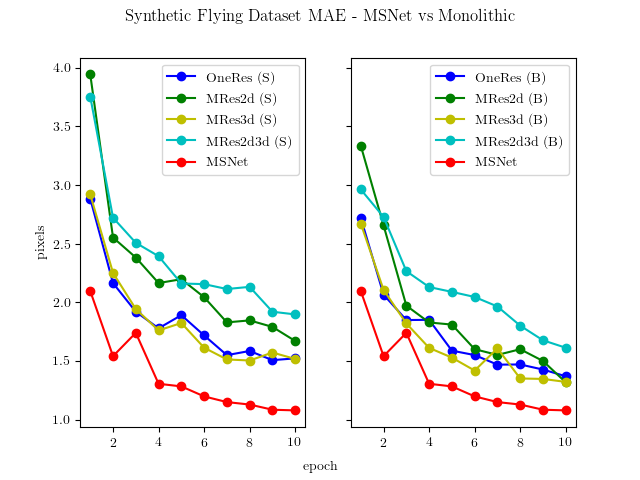

In [65]:
fig_name = 'freiburg_msnet_vs_monolithic_mae.pdf'
title = "Synthetic Flying Dataset MAE - MSNet vs Monolithic"
checkpoints = freiburg_standard_checkpoint
mae_or_pcg = "mae"
tr_te_val = "test_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


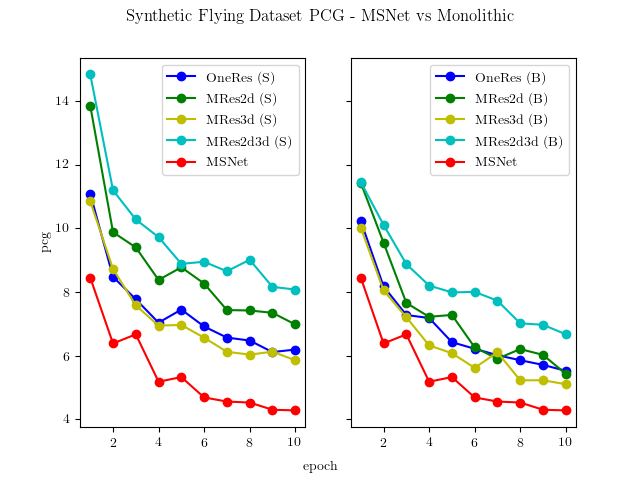

In [66]:
fig_name = 'freiburg_msnet_vs_monolithic_pcg.pdf'
title = "Synthetic Flying Dataset PCG - MSNet vs Monolithic"
checkpoints = freiburg_standard_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "test_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


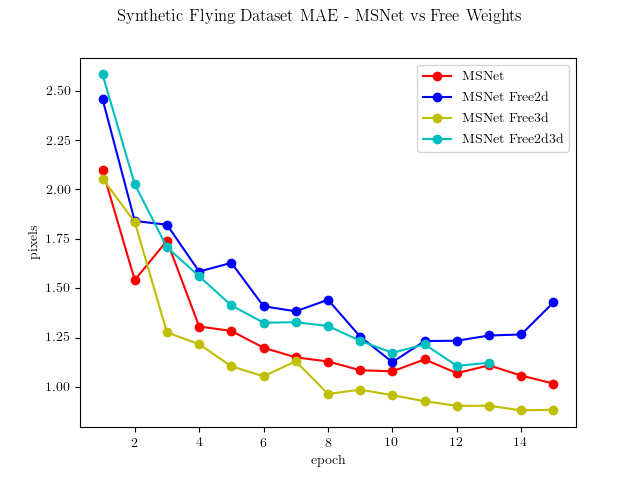

In [67]:
fig_name = 'freiburg_msnet_vs_free_weights_mae.pdf'
title = "Synthetic Flying Dataset MAE - MSNet vs Free Weights"
checkpoints = freiburg_last_checkpoint
mae_or_pcg = "mae"
tr_te_val = "test_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


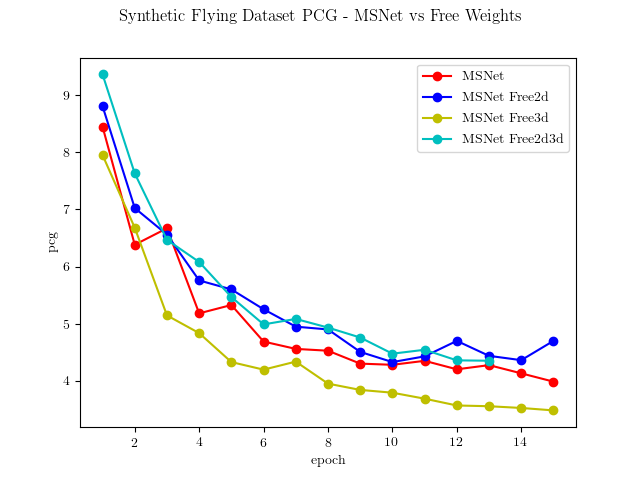

In [68]:
fig_name = 'freiburg_msnet_vs_free_weights_pcg.pdf'
title = "Synthetic Flying Dataset PCG - MSNet vs Free Weights"
checkpoints = freiburg_last_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "test_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

# KITTI 2015

<IPython.core.display.Javascript object>


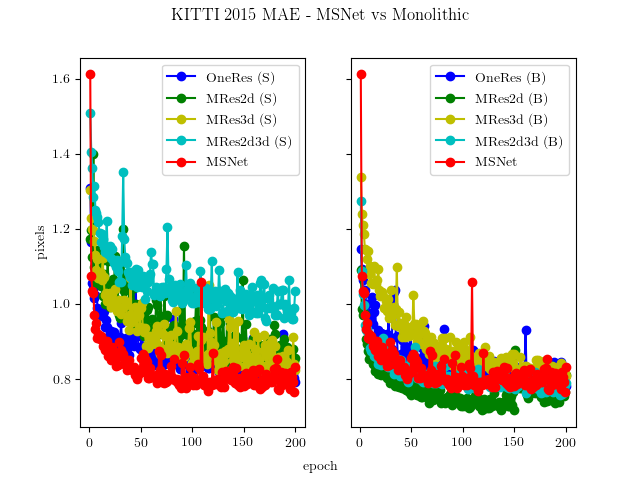

In [69]:
fig_name = 'kitti2015_msnet_vs_monolithic_mae.pdf'
title = "KITTI 2015 MAE - MSNet vs Monolithic"
checkpoints = kitti_2015_last_checkpoint
mae_or_pcg = "mae"
tr_te_val = "val_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


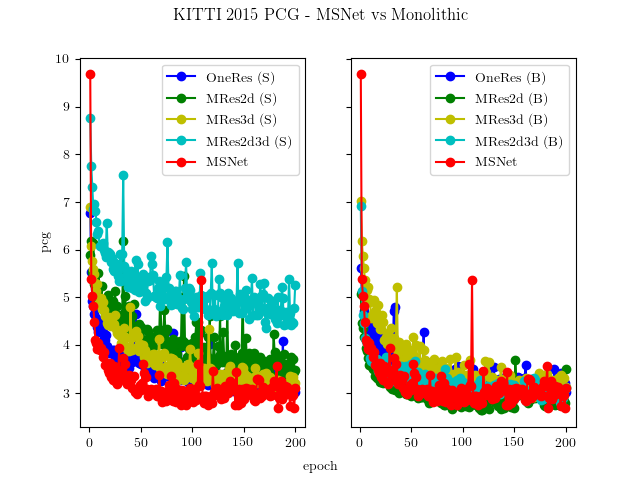

In [70]:
fig_name = 'kitti2015_msnet_vs_monolithic_pcg.pdf'
title = "KITTI 2015 PCG - MSNet vs Monolithic"
checkpoints = kitti_2015_last_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "val_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


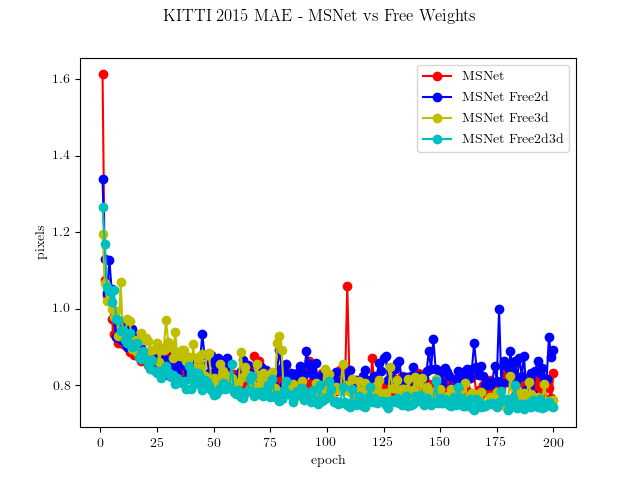

In [71]:
fig_name = 'kitti2015_msnet_vs_free_weights_mae.pdf'
title = "KITTI 2015 MAE - MSNet vs Free Weights"
checkpoints = kitti_2015_last_checkpoint
mae_or_pcg = "mae"
tr_te_val = "val_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


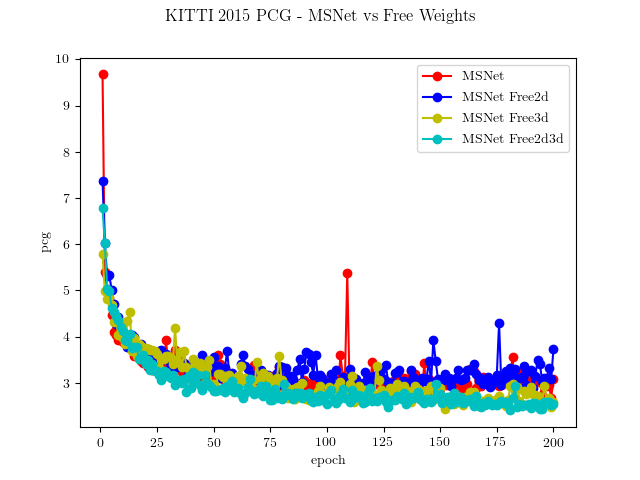

In [72]:
fig_name = 'kitti2015_msnet_vs_free_weights_pcg.pdf'
title = "KITTI 2015 PCG - MSNet vs Free Weights"
checkpoints = kitti_2015_last_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "val_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

In [73]:
# KITTI 2012

<IPython.core.display.Javascript object>


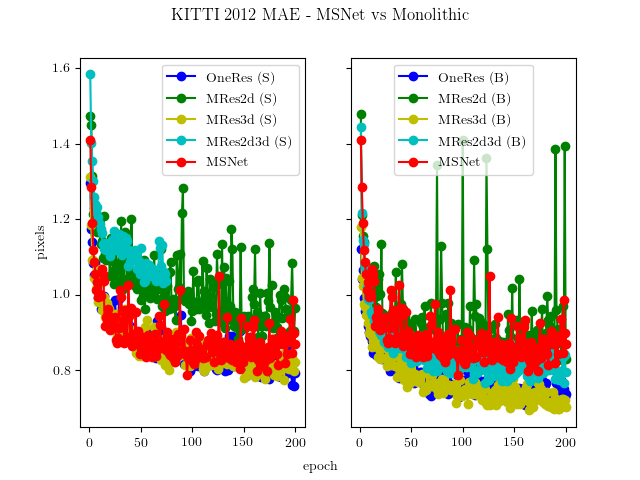

In [74]:
fig_name = 'kitti2012_msnet_vs_monolithic_mae.pdf'
title = "KITTI 2012 MAE - MSNet vs Monolithic"
checkpoints = kitti_2012_last_checkpoint
mae_or_pcg = "mae"
tr_te_val = "val_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


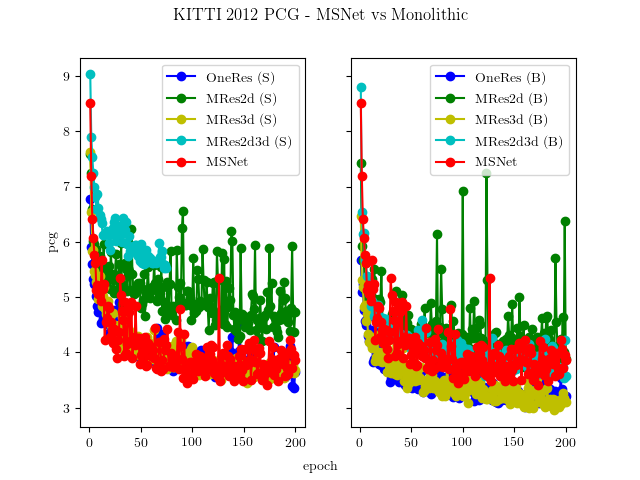

In [75]:
fig_name = 'kitti2012_msnet_vs_monolithic_pcg.pdf'
title = "KITTI 2012 PCG - MSNet vs Monolithic"
checkpoints = kitti_2012_last_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "val_full"
plot_msnet_vs_monolithic(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


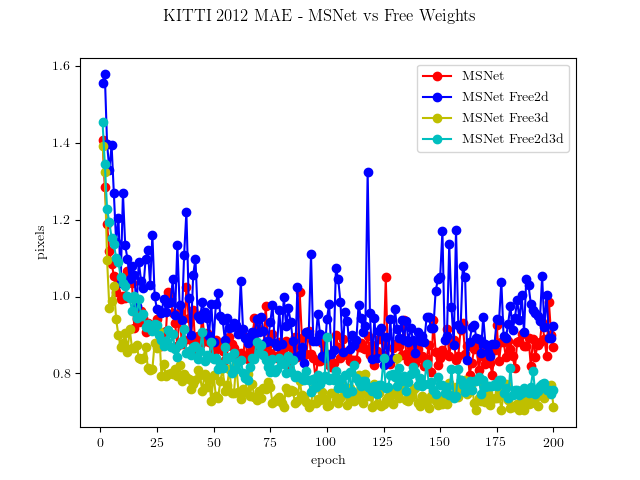

In [76]:
fig_name = 'kitti2012_msnet_vs_free_weights_mae.pdf'
title = "KITTI 2012 MAE - MSNet vs Free Weights"
checkpoints = kitti_2012_last_checkpoint
mae_or_pcg = "mae"
tr_te_val = "val_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)

<IPython.core.display.Javascript object>


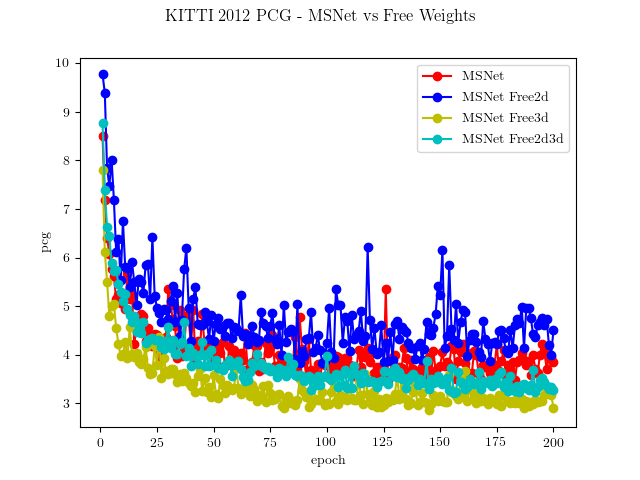

In [77]:
fig_name = 'kitti2012_msnet_vs_free_weights_pcg.pdf'
title = "KITTI 2012 PCG - MSNet vs Free Weights"
checkpoints = kitti_2012_last_checkpoint
mae_or_pcg = "pcg"
tr_te_val = "val_full"
plot_msnet_vs_free_weights(fig_name, title, checkpoints, mae_or_pcg, tr_te_val)